In [71]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

import warnings
warnings.filterwarnings('ignore')

In [72]:
file_path = os.path.join('..', 'aggregated_data.csv')
data = pd.read_csv(file_path)

# inflation adjustment
base_cpi = data['CPI_US'].iloc[-1]
data['AVG_PRICE_AUCTION'] = data['AVG_PRICE_AUCTION'] * (base_cpi/data['CPI_US'])
data['DATE'] = pd.to_datetime(data['DATE'])

data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop( # drop columns not used for training
    ['avg_price_steers_ML1', 
     'avg_price_steers_ML1_2', 
     'avg_price_heifers_ML1', 
     'avg_price_heifers_ML1_2', 
     'NATIONAL_AUCTION_SALES', 
     'NATIONAL_TOTAL_SALES', 
     'TEXAS_AUCTION_SALES', 
     'CORN_FUTURES_TYPICAL_PRICE', 
     'DIESEL_RETAIL_PRICE', 
     'ALFAFA_HAY_PPI', 
     'CORN_PPI',
     'FEEDER_CATTLE_FUTURES_TYPICAL_PRICE',
     'US_MXN_RATES',
     'CPI_US',
     'FEDERAL_INTEREST_RATE',
     'US_MXN_RATES',
     ], axis=1)

In [73]:
def evaluate_forecast(model_name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual,predicted)
    
    acc = 100.0 * (1 - mae / actual.mean()) if actual.mean() != 0 else float('nan')
    print(f"\n[{model_name}] Test Performance:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, Accuracy: {acc:.2f}%")

In [74]:
# freq = pd.infer_freq(data.index)
# print('Inferred frequency:', freq)

# FIND WHICH DATA POINTS ARE MISSING
start_date = data.index.min()
end_date = data.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='W-FRI')
missing_dates = full_index.difference(data.index)
# print("Missing Dates:")
# print(missing_dates)

# REINDEX DATA & IMPUTE MISSING VALUES
# duplicates = data.index[data.index.duplicated()]
# print("Duplicate date entries:\n", duplicates)
arima_data = data.reindex(full_index).interpolate(method='linear')
price_series = arima_data['AVG_PRICE_AUCTION']

freq = pd.infer_freq(arima_data.index)
# print('Inferred frequency:', freq)

# PERFORM DIFFERENCING
price_series_diff = price_series.diff().dropna()

# CHECK FOR STATIONARY WITH ADF TEST
# adf_test = adfuller(price_series)
# print(f'ADF Statistic: {adf_test[0]}')
# print(f'p-value: {adf_test[1]}')

adf_test2 = ADFTest(alpha=0.05)
print(adf_test2.should_diff(price_series_diff))

# price_series_diff.plot()

n = len(price_series)
train_size = int(n * 0.8)

train = price_series.iloc[:train_size]
test = price_series.iloc[train_size:]

# arima_model = auto_arima(
#     train, start_p=0, d=1, start_q=0,
#     max_p=5, max_d=5, max_q=5, start_P=0,
#     D=1, start_Q=0, max_P=5, max_D=5,
#     max_Q=5, m=52, seasonal=True,
#     error_action='warn', trace=True,
#     suppress_warnings=True, stepwise=True,
#     random_state=20, n_fits=50
# )

# model = auto_arima(y=train,
#                   start_p=0, start_q=0,
#                   max_p=3, max_q=3,     # Reduced from 5 to limit complexity
#                   m=12,                 
#                   seasonal=True,
#                   max_P=2, max_Q=2,     # Add limits to seasonal components
#                   d=1,                  # Force first differencing
#                   D=1,                  # Force seasonal differencing
#                   trace=True,
#                   error_action='ignore',
#                   suppress_warnings=True,
#                   stepwise=True,
#                   random_state=42,
#                   information_criterion='aic',  # Use AIC for model selection
#                   n_fits=30)            # Reduced number of fits

# model = auto_arima(train,
#                   start_p=0, start_q=0,
#                   max_p=5, max_q=5,
#                   m=12,
#                   seasonal=True,
#                   d=None,
#                   D=None,
#                   trace=True,
#                   error_action='ignore',
#                   suppress_warnings=True,
#                   stepwise=True,
#                   random_state=42,
#                   # information_criterion='bic',
#                   # method='lbfgs',
#                   n_fits=30)    



(np.float64(0.01), np.False_)


In [ ]:
# CREATE AND TRAIN ARIMA MODEL
model = ARIMA(train, order=(3, 1, 0), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit()
# print(model_fit.summary())

# FORECAST DATA
test_forecast = model_fit.forecast(steps=len(test))
train_forecast = model_fit.forecast(steps=len(train))

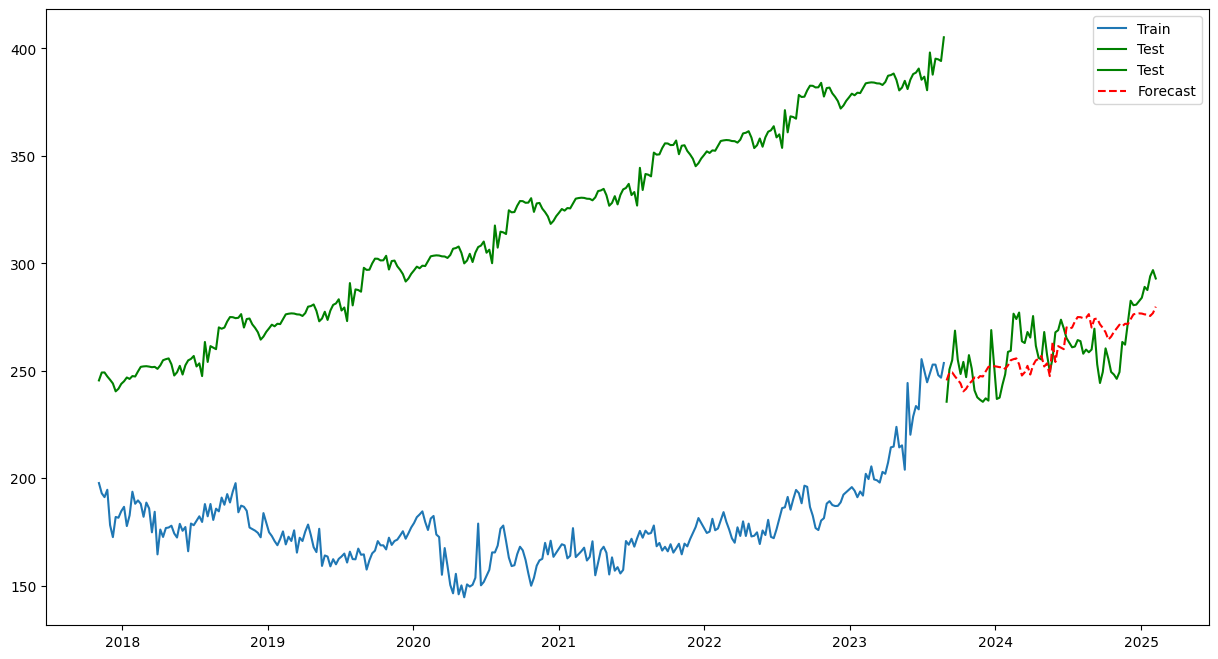

In [82]:
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(train.index, train_forecast, label='Test', color='green')
plt.plot(test.index, test_forecast, label='Forecast', color='red', linestyle='--')

plt.legend()
plt.savefig(os.path.join('..', 'figures', 'arima_plot.png'), dpi=300)
plt.show()

In [83]:
evaluate_forecast('ARIMA: Training Data', train, train_forecast)
evaluate_forecast('ARIMA: Testing Data', test, test_forecast)



[ARIMA: Training Data] Test Performance:
MAE: 140.18, RMSE: 146.16, R²: -55.27, Accuracy: 21.40%

[ARIMA: Testing Data] Test Performance:
MAE: 11.39, RMSE: 13.08, R²: 0.22, Accuracy: 95.63%
